Deep MaxEnt IRL training ..
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


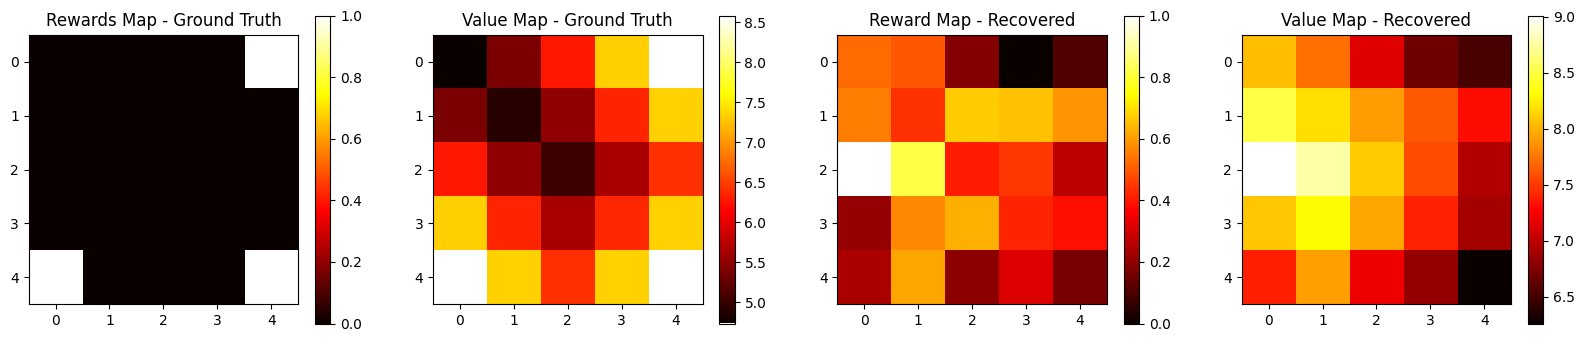

In [8]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
import matplotlib.pyplot as plt

#############################
# Utility Functions
#############################
def normalize(vals):
    """
    Normalize to (0, max_val)
    Input:
        vals: 1d array
    """
    min_val = np.min(vals)
    max_val = np.max(vals)
    if max_val == min_val:
        return vals - min_val
    return (vals - min_val) / (max_val - min_val)

def sigmoid(xs):
    """
    Sigmoid function
    Inputs:
        xs: 1d array
    """
    return [1 / (1 + math.exp(-x)) for x in xs]

#############################
# GridWorld Environment
#############################
class GridWorld(object):
    """
    Grid world environment
    """
    def __init__(self, grid, terminals, trans_prob=1):
        self.height = len(grid)
        self.width = len(grid[0])
        self.n_states = self.height * self.width
        for i in range(self.height):
            for j in range(self.width):
                grid[i][j] = str(grid[i][j])

        self.terminals = terminals
        self.grid = grid
        self.neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (0, 0)]
        self.actions = [0, 1, 2, 3, 4]
        self.n_actions = len(self.actions)
        # Directions: right, left, down, up, stay
        self.dirs = {0: 'r', 1: 'l', 2: 'd', 3: 'u', 4: 's'}

        self.trans_prob = trans_prob

    def is_terminal(self, state):
        if tuple(state) in self.terminals:
            return True
        else:
            return False

    def get_transition_states_and_probs(self, state, action):
        if self.is_terminal(tuple(state)):
            return [(tuple(state), 1)]

        if self.trans_prob == 1:
            inc = self.neighbors[action]
            nei_s = (state[0] + inc[0], state[1] + inc[1])
            if (0 <= nei_s[0] < self.height and 0 <= nei_s[1] < self.width and 
                self.grid[nei_s[0]][nei_s[1]] != 'x'):
                return [(nei_s, 1)]
            else:
                # If invalid move, stay in place
                return [(state, 1)]
        else:
            mov_probs = np.zeros([self.n_actions])
            mov_probs[action] = self.trans_prob
            mov_probs += (1 - self.trans_prob) / self.n_actions

            for a in range(self.n_actions):
                inc = self.neighbors[a]
                nei_s = (state[0] + inc[0], state[1] + inc[1])
                if (nei_s[0] < 0 or nei_s[0] >= self.height or
                    nei_s[1] < 0 or nei_s[1] >= self.width or 
                    self.grid[nei_s[0]][nei_s[1]] == 'x'):
                    mov_probs[self.n_actions - 1] += mov_probs[a]
                    mov_probs[a] = 0

            res = []
            for a in range(self.n_actions):
                if mov_probs[a] != 0:
                    inc = self.neighbors[a]
                    nei_s = (state[0] + inc[0], state[1] + inc[1])
                    res.append((nei_s, mov_probs[a]))
            return res

    def get_reward(self, state):
        if self.grid[state[0]][state[1]] != 'x':
            return float(self.grid[state[0]][state[1]])
        else:
            return 0

    def get_transition_mat(self):
        N_STATES = self.height * self.width
        N_ACTIONS = len(self.actions)
        P_a = np.zeros((N_STATES, N_STATES, N_ACTIONS))
        for si in range(N_STATES):
            posi = self.idx2pos(si)
            for a in range(N_ACTIONS):
                probs = self.get_transition_states_and_probs(posi, a)
                for posj, prob in probs:
                    sj = self.pos2idx(posj)
                    P_a[si, sj, a] = prob
        return P_a

    def pos2idx(self, pos):
        return pos[0] + pos[1] * self.height

    def idx2pos(self, idx):
        return (idx % self.height, idx // self.height)

    # For model-free simulation
    def reset(self, start_pos):
        self._cur_state = start_pos

    def step(self, action):
        if self.is_terminal(self._cur_state):
            return self._cur_state, action, self._cur_state, self.get_reward(self._cur_state), True

        st_prob = self.get_transition_states_and_probs(self._cur_state, action)
        sampled_idx = np.random.choice(np.arange(0, len(st_prob)), p=[prob for st, prob in st_prob])
        last_state = self._cur_state
        next_state = st_prob[sampled_idx][0]
        reward = self.get_reward(last_state)
        self._cur_state = next_state
        return last_state, action, next_state, reward, False

#############################
# Value Iteration
#############################
def value_iteration(P_a, rewards, gamma, error=0.01, deterministic=True):
    N_STATES, _, N_ACTIONS = np.shape(P_a)
    values = np.zeros([N_STATES])

    while True:
        values_tmp = values.copy()
        for s in range(N_STATES):
            values[s] = max([sum([P_a[s, s1, a]*(rewards[s] + gamma*values_tmp[s1]) 
                                 for s1 in range(N_STATES)]) for a in range(N_ACTIONS)])
        if max([abs(values[s] - values_tmp[s]) for s in range(N_STATES)]) < error:
            break

    if deterministic:
        policy = np.zeros([N_STATES])
        for s in range(N_STATES):
            policy[s] = np.argmax([sum([P_a[s, s1, a]*(rewards[s] + gamma*values[s1])
                                        for s1 in range(N_STATES)])
                                   for a in range(N_ACTIONS)])
        return values, policy
    else:
        policy = np.zeros([N_STATES, N_ACTIONS])
        for s in range(N_STATES):
            v_s = np.array([sum([P_a[s, s1, a]*(rewards[s] + gamma*values[s1]) 
                                for s1 in range(N_STATES)]) for a in range(N_ACTIONS)])
            policy[s, :] = v_s / np.sum(v_s)
        return values, policy

#############################
# IRL Related Code
#############################
Step = namedtuple('Step', 'cur_state action next_state reward done')

def compute_state_visitation_freq(P_a, gamma, trajs, policy, deterministic=True):
    """
    Compute the expected state visitation frequencies p(s| theta, T) 
    using dynamic programming.

    Inputs:
        P_a         NxNxN_ACTIONS matrix - transition dynamics
        gamma       float - discount factor
        trajs       list of list of Steps - collected from expert
        policy      Nx1 vector (or NxN_ACTIONS if deterministic=False) - policy
        deterministic bool - whether the policy is deterministic

    Returns:
        p           Nx1 vector - state visitation frequencies
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)
    T = len(trajs[0])
    mu = np.zeros([N_STATES, T]) 

    for traj in trajs:
        mu[traj[0].cur_state, 0] += 1
    mu[:,0] = mu[:,0] / len(trajs)

    for t in range(T-1):
        for pre_s in range(N_STATES):
            a = int(policy[pre_s])
            if deterministic:
                for s in range(N_STATES):
                    mu[s, t+1] += mu[pre_s, t] * P_a[pre_s, s, a]
            else:
                for a1 in range(N_ACTIONS):
                    for s in range(N_STATES):
                        mu[s, t+1] += mu[pre_s, t] * P_a[pre_s, s, a1] * policy[pre_s, a1]
    
    p = np.sum(mu, axis=1)
    return p

def demo_svf(trajs, n_states):
    """
    Compute state visitation frequencies from demonstrations.

    Input:
        trajs       list of list of Steps - collected from expert

    Returns:
        p           Nx1 vector - state visitation frequencies   
    """
    p = np.zeros(n_states)
    for traj in trajs:
        for step in traj:
            p[step.cur_state] += 1
    p = p / len(trajs)
    return p

#############################
# PyTorch Deep IRL Model
#############################
class DeepIRLFC(nn.Module):
    def __init__(self, n_input, lr, n_h1=400, n_h2=300, l2=10):
        super(DeepIRLFC, self).__init__()
        self.n_input = n_input
        self.lr = lr
        self.n_h1 = n_h1
        self.n_h2 = n_h2
        self.l2 = l2

        self.fc1 = nn.Linear(n_input, n_h1)
        self.fc2 = nn.Linear(n_h1, n_h2)
        self.reward_layer = nn.Linear(n_h2, 1)

        # Initialize weights similar to TF variance scaling:
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.reward_layer.weight, mode='fan_in', nonlinearity='linear')

        self.optimizer = optim.SGD(self.parameters(), lr=lr)

    def forward(self, states):
        x = self.fc1(states)
        x = F.elu(x)
        x = self.fc2(x)
        x = F.elu(x)
        r = self.reward_layer(x)
        return r

    def get_rewards(self, states):
        with torch.no_grad():
            states_t = torch.from_numpy(states).float()
            rewards = self.forward(states_t)
            return rewards.detach().numpy().flatten()

    def get_theta(self):
        return [p.detach().numpy() for p in self.parameters()]

    def apply_grads(self, feat_map, grad_r):
        """
        Apply gradients to the neural network based on the difference between
        expert and expected state visitation frequencies.

        Inputs:
            feat_map    NxD numpy array - feature map
            grad_r      Nx1 numpy array - gradient of rewards

        Returns:
            grad_theta  list of numpy arrays - gradients for each parameter
            l2_loss     float - L2 regularization loss
            grad_norm   float - norm of gradients
        """
        # Convert to PyTorch tensors
        feat_map_t = torch.from_numpy(feat_map).float()
        grad_r_t = torch.from_numpy(grad_r).float()

        self.optimizer.zero_grad()
        rewards = self.forward(feat_map_t)  # Nx1

        # Loss: -sum(grad_r * reward) + l2 * sum(param^2)
        loss = - torch.sum(grad_r_t * rewards)
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.sum(param ** 2)
        loss = loss + self.l2 * l2_loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.parameters(), 100.0)
        self.optimizer.step()

        # Collect gradients
        grad_theta = [p.grad.detach().cpu().numpy() if p.grad is not None else None for p in self.parameters()]
        l2_loss_val = l2_loss.detach().cpu().item()

        # Compute gradient norm
        grad_norm = 0.0
        for p in self.parameters():
            if p.grad is not None:
                grad_norm += p.grad.data.norm().item() ** 2
        grad_norm = float(math.sqrt(grad_norm))

        return grad_theta, l2_loss_val, grad_norm

#############################
# Deep MaxEnt IRL Procedure
#############################
def deep_maxent_irl(feat_map, P_a, gamma, trajs, lr, n_iters):
    N_STATES, _, N_ACTIONS = np.shape(P_a)
    nn_r = DeepIRLFC(feat_map.shape[1], lr, n_h1=400, n_h2=300, l2=10)

    # Find state visitation frequencies using demonstrations
    mu_D = demo_svf(trajs, N_STATES)

    for iteration in range(n_iters):
        if iteration % max(1, n_iters // 10) == 0:
            print('Iteration: {}'.format(iteration))
        # Compute the reward matrix
        rewards = nn_r.get_rewards(feat_map)
        # Compute policy 
        _, policy = value_iteration(P_a, rewards, gamma, error=0.01, deterministic=True)
        # Compute expected SVF
        mu_exp = compute_state_visitation_freq(P_a, gamma, trajs, policy, deterministic=True)
        # Compute gradients on rewards:
        grad_r = mu_D - mu_exp
        # Apply gradients to the neural network
        grad_theta, l2_loss, grad_norm = nn_r.apply_grads(feat_map, grad_r)

    rewards = nn_r.get_rewards(feat_map)
    return normalize(rewards)

#############################
# Main Execution Flow
#############################
def generate_demonstrations(gw, policy, n_trajs=100, len_traj=20, rand_start=False, start_pos=[0,0]):
    """
    Gather expert demonstrations.

    Inputs:
        gw          GridWorld instance
        policy      Nx1 numpy array
        n_trajs     int - number of trajectories to generate
        len_traj    int - length of each trajectory
        rand_start  bool - whether to start at random positions
        start_pos   list - fixed start position if rand_start is False

    Returns:
        trajs       list of trajectories
    """
    trajs = []
    for i in range(n_trajs):
        if rand_start:
            start_pos = [np.random.randint(0, gw.height), np.random.randint(0, gw.width)]

        episode = []
        gw.reset(start_pos)
        cur_s = start_pos
        for _ in range(len_traj):
            a = int(policy[gw.pos2idx(cur_s)])
            cur_s, action, next_s, r, done = gw.step(a)
            episode.append(Step(cur_state=gw.pos2idx(cur_s), action=action, 
                                next_state=gw.pos2idx(next_s), reward=r, done=done))
            if done:
                break
        trajs.append(episode)
    return trajs

def main():
    #############################
    # Parameter Definitions
    #############################
    # Environment Parameters
    H = 5  # Height of the gridworld
    W = 5  # Width of the gridworld
    R_MAX = 1  # Maximum reward value

    # IRL Parameters
    GAMMA = 0.9  # Discount factor
    ACT_RAND = 0.3  # Probability of acting randomly
    N_TRAJS = 200  # Number of expert trajectories
    L_TRAJ = 100  # Length of each trajectory
    RAND_START = True  # Whether to start at random positions
    LEARNING_RATE = 0.001  # Learning rate for the neural network
    N_ITERS = 100  # Number of IRL iterations

    #############################
    # Environment Setup
    #############################
    # Define the reward map (ground truth)
    rmap_gt = np.zeros([H, W])
    rmap_gt[H-1, W-1] = R_MAX
    rmap_gt[0, W-1] = R_MAX
    rmap_gt[H-1, 0] = R_MAX

    # Initialize GridWorld
    gw = GridWorld(rmap_gt, terminals={}, trans_prob=1 - ACT_RAND)
    rewards_gt = np.reshape(rmap_gt, H * W, order='F')
    P_a = gw.get_transition_mat()

    # Compute ground truth values and policy using value iteration
    values_gt, policy_gt = value_iteration(P_a, rewards_gt, GAMMA, error=0.01, deterministic=True)

    # Use identity matrix as feature map
    feat_map = np.eye(H * W)

    #############################
    # Generate Expert Demonstrations
    #############################
    trajs = generate_demonstrations(gw, policy_gt, n_trajs=N_TRAJS, len_traj=L_TRAJ, rand_start=RAND_START)

    #############################
    # Deep MaxEnt IRL Training
    #############################
    print('Deep MaxEnt IRL training ..')
    rewards = deep_maxent_irl(feat_map, P_a, GAMMA, trajs, LEARNING_RATE, N_ITERS)

    #############################
    # Compute Recovered Values and Policy
    #############################
    values, _ = value_iteration(P_a, rewards, GAMMA, error=0.01, deterministic=True)

    #############################
    # Visualization
    #############################
    plt.figure(figsize=(20, 4))
    
    # Ground Truth Rewards
    plt.subplot(1, 4, 1)
    plt.imshow(np.reshape(rewards_gt, (H, W), order='F'), cmap='hot', interpolation='nearest')
    plt.title('Rewards Map - Ground Truth')
    plt.colorbar()
    
    # Ground Truth Values
    plt.subplot(1, 4, 2)
    plt.imshow(np.reshape(values_gt, (H, W), order='F'), cmap='hot', interpolation='nearest')
    plt.title('Value Map - Ground Truth')
    plt.colorbar()
    
    # Recovered Rewards
    plt.subplot(1, 4, 3)
    plt.imshow(np.reshape(rewards, (H, W), order='F'), cmap='hot', interpolation='nearest')
    plt.title('Reward Map - Recovered')
    plt.colorbar()
    
    # Recovered Values
    plt.subplot(1, 4, 4)
    plt.imshow(np.reshape(values, (H, W), order='F'), cmap='hot', interpolation='nearest')
    plt.title('Value Map - Recovered')
    plt.colorbar()
    
    plt.show()

if __name__ == "__main__":
    main()
